In [12]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

import jbolo.jbolo_funcs as jf
from jbolo.utils import load_sim
from jbolo.monte_carlo import InputParam, OutputParam, SimulationMC

## change this to your path to jbolo
os.environ["JBOLO_PATH"] = "/fake/path/to/software/install/"
## change this to your path where the base sim yaml is saved
base_sim_path = '/fake/path/to/file/SO_MP_20250210.yaml'

## Define what inputs you want to vary

In [9]:
"""
functions for the `set_sim_param` functions in `monte_carlo.InputParam`. 
If I can ever figure out a less annoying way to do this, I will
"""
def _set_win_r(sim, val):
    sim['optical_elements']['window']['reflection'] = val
def _set_win_tau(sim, val):
    sim['optical_elements']['window']['thickness'] = val
def _set_win_index(sim, val):
    sim['optical_elements']['window']['index'] = val
def _set_win_tand(sim, val):
    sim['optical_elements']['window']['loss_tangent'] = val


## get an InputParam for a window with reflection r
def get_win_R_input(r):
    return InputParam(
        name='window_reflections', generate = lambda n_sims: r*np.ones((n_sims,)), 
        set_sim_param = _set_win_r,
    )

## vary the window's loss tangent using a normal distribution
win_loss_tan = InputParam(
    name='window_loss_tangent', 
    generate = lambda n_sims: np.random.normal( loc=3.05e-4, scale=0.05e-4, size=(n_sims,)),
    set_sim_param = _set_win_tand,
)
## vary the window's index of refraction using a normal distribution
win_index = InputParam(
    name='window_index', 
    generate = lambda n_sims: np.random.normal( loc=1.5325, scale=0.0075, size=(n_sims,)),
    set_sim_param = _set_win_index,
)
## always set the window thickness to 20 mm
win_thickness_20mm = InputParam(
    name='window_thickness', generate = lambda n_sims: 0.02*np.ones((n_sims,)), 
    set_sim_param = _set_win_tau,
)

## Define what outputs you want to track

In [10]:
my_outputs = [
    OutputParam(
        name='window_eff_avg', by_channel=True,
        extract = lambda sim, ch : sim['outputs'][ch]['optics']['window']['effic_avg']
    ),
    OutputParam(
        name='window_pW', by_channel=True,
        extract = lambda sim, ch : sim['outputs'][ch]['optics']['window']['P_opt']
    ),
    OutputParam(
        name='NET_C_wafer', by_channel=True,
        extract = lambda sim, ch : sim['outputs'][ch]['NET_C_wafer']
    ),
]

## Setup the Monte Carlos

In [14]:
mc_1 = SimulationMC(name="R=0.003", base_sim=base_sim_path,
    inputs=[get_win_R_input(0.003), win_loss_tan, win_index, win_thickness_20mm], 
    outputs = my_outputs,
)

mc_2 = SimulationMC( name = "R=0.013", base_sim=base_sim_path,
    inputs=[get_win_R_input(0.013), win_loss_tan, win_index, win_thickness_20mm], 
    outputs = my_outputs,
)

mc_3 = SimulationMC( name = "R=0.025", base_sim=base_sim_path,
    inputs=[get_win_R_input(0.025), win_loss_tan, win_index, win_thickness_20mm], 
    outputs = my_outputs,
)

mcs_to_run = [mc_1, mc_2, mc_3]

## Run the Monte Carlo

In [15]:
for mc in mcs_to_run:
    print(mc.name)
    mc.setup( n_sims = 500)
    mc.run()

R=0.003
R=0.013
R=0.025


## Look at Results

In [16]:
## print the output wafer NETs: 
for mc in mcs_to_run:
    print( 
        mc.name, "\t", "\t".join( [f"{round(1e6*np.mean(mc.outputs['NET_C_wafer'][ch]),2)}+/-{round(1e6*np.std(mc.outputs['NET_C_wafer'][ch]),2)}" for ch in mc.channels]) 
    )

R=0.003 	 10.54+/-0.03	14.69+/-0.06
R=0.013 	 10.61+/-0.03	14.8+/-0.06
R=0.025 	 10.69+/-0.03	14.93+/-0.06


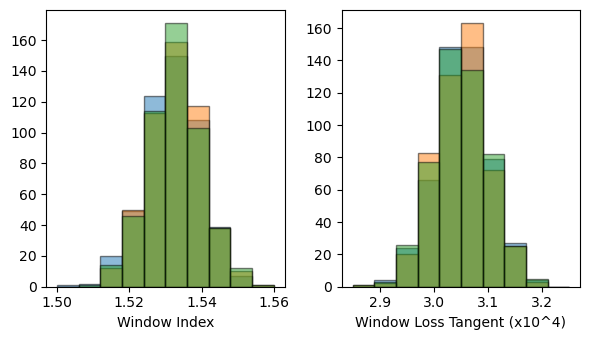

In [17]:
fig = plt.figure(figsize=(6,3.5))
plt.subplot(1,2,1)
plt.hist( mc_1.inputs['window_index'], range=(1.5,1.56), alpha=0.5, ec='k')
plt.hist( mc_2.inputs['window_index'], range=(1.5,1.56), alpha=0.5, ec='k' )
plt.hist( mc_3.inputs['window_index'], range=(1.5,1.56), alpha=0.5, ec='k' )
plt.xlabel("Window Index") 


plt.subplot(1,2,2)
plt.hist( 1e4*mc_1.inputs['window_loss_tangent'], range=(2.85,3.25), alpha=0.5, ec='k')
plt.hist( 1e4*mc_2.inputs['window_loss_tangent'], range=(2.85,3.25), alpha=0.5, ec='k' )
plt.hist( 1e4*mc_3.inputs['window_loss_tangent'], range=(2.85,3.25), alpha=0.5, ec='k' )
plt.xlabel("Window Loss Tangent (x10^4)") 
fig.tight_layout()

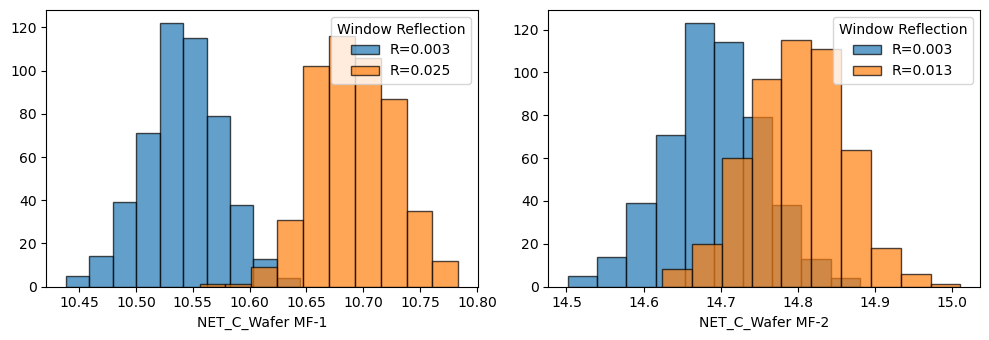

In [18]:
fig = plt.figure(figsize=(10, 3.5))
plt.subplot(1,2,1)
for mc in [mc_1, mc_3]:
    plt.hist( 1e6*mc.outputs['NET_C_wafer']['MF_1'], label=mc.name, alpha=0.7, ec='k')
plt.legend(title='Window Reflection')

plt.xlabel("NET_C_Wafer MF-1")

plt.subplot(1,2,2)
for mc in [mc_1, mc_2]:
    plt.hist( 1e6*mc.outputs['NET_C_wafer']['MF_2'], label=mc.name, alpha=0.7, ec='k')
plt.legend(title='Window Reflection')
plt.xlabel("NET_C_Wafer MF-2")
fig.tight_layout()

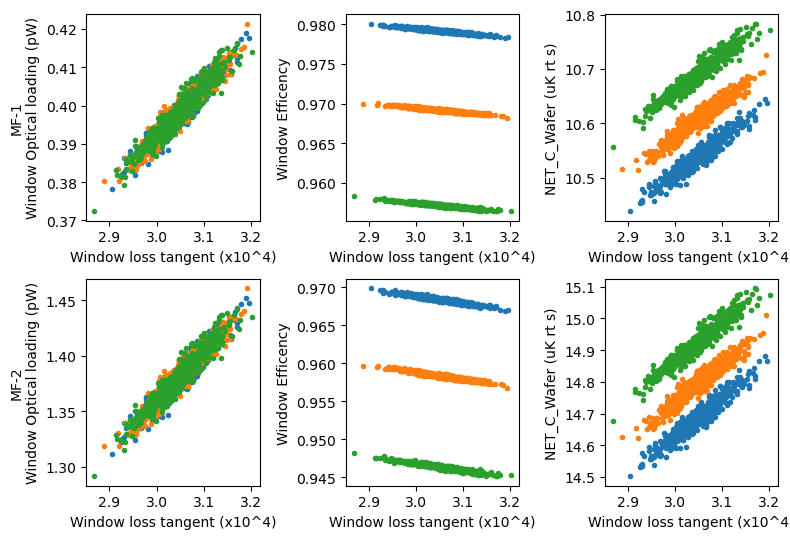

In [19]:
fig = plt.figure(figsize=(8, 5.5))


plt.subplot(2,3,1)
for mc in [mc_1, mc_2, mc_3]:
    plt.plot( 1e4*mc.inputs['window_loss_tangent'], 1e12*mc.outputs['window_pW']['MF_1'], '.')
plt.xlabel("Window loss tangent (x10^4)")
plt.ylabel("MF-1\nWindow Optical loading (pW)")
    
plt.subplot(2,3,2)
for mc in [mc_1, mc_2, mc_3]:
    plt.plot( 1e4*mc.inputs['window_loss_tangent'], mc.outputs['window_eff_avg']['MF_1'], '.')
plt.xlabel("Window loss tangent (x10^4)")
plt.ylabel("Window Efficency")
plt.subplot(2,3,3)
for mc in [mc_1, mc_2, mc_3]:
    plt.plot( 1e4*mc.inputs['window_loss_tangent'], 1e6*mc.outputs['NET_C_wafer']['MF_1'], '.')
plt.xlabel("Window loss tangent (x10^4)")
plt.ylabel("NET_C_Wafer (uK rt s)")

plt.subplot(2,3,4)
for mc in [mc_1, mc_2, mc_3]:
    plt.plot( 1e4*mc.inputs['window_loss_tangent'], 1e12*mc.outputs['window_pW']['MF_2'], '.')
plt.xlabel("Window loss tangent (x10^4)")
plt.ylabel("MF-2\nWindow Optical loading (pW)")
    
plt.subplot(2,3,5)
for mc in [mc_1, mc_2, mc_3]:
    plt.plot( 1e4*mc.inputs['window_loss_tangent'], mc.outputs['window_eff_avg']['MF_2'], '.')
plt.xlabel("Window loss tangent (x10^4)")
plt.ylabel("Window Efficency")
plt.subplot(2,3,6)
for mc in [mc_1, mc_2, mc_3]:
    plt.plot( 1e4*mc.inputs['window_loss_tangent'], 1e6*mc.outputs['NET_C_wafer']['MF_2'], '.')
plt.xlabel("Window loss tangent (x10^4)")
plt.ylabel("NET_C_Wafer (uK rt s)")

fig.tight_layout()